In [1]:
import warnings
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from prettytable import PrettyTable
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "RdYlGn",
        square=True, 
        cbar_kws={'shrink':.5 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='black',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features for Training Dataset', y=1.05, size=15)


In [2]:
SampleChurn = pd.read_csv('D:\Ooredoo internship\Churn Project\Data\SAMPLE_CHURN.csv', delimiter=';')
MonthlyAggregationSample = pd.read_csv('D:\Ooredoo internship\Churn Project\Data\MONTHLY_AGGREGATION_SAMPLE.csv', delimiter=';')

# Initial thoughts 
    From the first examination I noticed that the two datasets are linked by a subscriber id. The first Dataset Sample_Churn contains general informationa about the client's activity as well as dates for the client's first call/first recharge which can can be explored later on to provide insight on our target variable which also happens to be present in this dataset 'churn'. The second dataset contains more personalized information about the customers such their phone types , their revnues their data traffic etc. 
    
    My strategy will be to clean each dataset seperately as there appears to be a huge amount of NAN values , which will be treated seperately depending on their importance. then I'll combine both datasets to create my final dataset and start predicting the churn rate and increasing accuarcy. as this is a churn rate study I believe I will be trying to improve the True Positive predictions as much as I can as this will be valuable information to ooredoo's marketing department allowing them to target these clients and hopefully get them to not leave the service. 
    
    
    Let's start cleaning.

# First Dataset : SampleChurn
## First column : subscriber_id 
This column should be safe to drop eventually , but since we'll need it to merge the two datasets eventually I will leave it for now.
## Second Column : msisdn 
This column contains the msisdn number for our clients, which is the Mobile Station International Subscriber Directory Number, this is basically a different type of unique identifier and I believe it's safe to drop altogether as i doubt the random number has any correlation with the target variable.
## Third Column : Sales_Channel_Description 
This column contains NAN values, perhaps it was intentionally deleted or the data was never gathered, regardless it should be dropped as it's basically noise.
## date  Column :  
I have a small idea about how to turn these columns into useful information , I think there might be a correlation in the time between the activation date and the first call date to our target variable.

Same with the time between the first call and last call date, I believe if this date is small that might indicate the client was a temporary one and wasn't interested in staying with ooredoo to start with so that might explain a percentage of the churn percentage.

Maybe there's a relation between the activation date and the first recharge date as it might capture the client's urgency towards using their phone number but this remains to be explored later in the feature transformation phase.

Last international call contains 1977 nan values leaving us with 23 values to work with , I believe this should be dropped as it could just provide white noise to our algorithm 
## First Recharge amount : 
This should give us a lot of insight towards the churn rate as it might give us an idea about the client's status financially as well as their commitment to the ooredoo SIM Card (i highly believe we will find this to be highly correlated with the revenue columns in the second dataset)
## Original operator : 
this is very important to see if first time ooredoo users are more loyal than other clients that changed services or not and we will see how it affects the performance of our model down the line.

## dat_remb_kridi_net    :
should be dropped alongside ported_in_request_date for the huge number of NAN values , additionally the date of the credit reimboursment doesn't offer  a lot of information on its own and since thedat attrib kridi is all nan this has to go as well

## SamplingProb and Weight : 
As important as these features are, they won't be available when we actually try to estimate the churn for our customers so it's meaningless to train the model on them

In [3]:
print(SampleChurn.isnull().sum())

churn                              0
subscriber_id                      0
msisdn                             0
sales_channel_description       2000
date_activation                    0
churn_date                       819
first_call_date                   50
last_call_date                    50
first_recharge_date              478
first_recharge_amount            478
last_international_call_date    1977
original_operator                  0
dat_attrib_kridi                2000
dat_remb_kridi_net              1667
ported_in_request_date          1982
SelectionProb                      0
SamplingWeight                     0
dtype: int64


In [4]:
#Dropping the : msisdn,Sales_Channel_Description,last_international_call_date,dat_attrib_kridi,dat_remb_kridi_net,ported_in_request_date columns
columns_to_drop = ['msisdn','sales_channel_description','last_international_call_date','dat_attrib_kridi','dat_remb_kridi_net','ported_in_request_date']
SampleChurn = SampleChurn.drop(columns_to_drop, axis=1)
# Convert dates to datetime format
parsed_dates = [pd.to_datetime(date, format='%d%b%Y:%H:%M:%S.%f') for date in SampleChurn['date_activation']]
SampleChurn['date_activation_parsed'] = parsed_dates
parsed_churn_dates = [pd.to_datetime(date, format='%d%b%Y:%H:%M:%S.%f') for date in SampleChurn['churn_date']]
SampleChurn['churn_date_parsed'] = parsed_churn_dates
parsed_first_call_date = [pd.to_datetime(date, format='%d%b%Y:%H:%M:%S.%f') for date in SampleChurn['first_call_date']]
SampleChurn['first_call_date_parsed'] = parsed_first_call_date
parsed_last_call_date = [pd.to_datetime(date, format='%d%b%Y:%H:%M:%S.%f') for date in SampleChurn['last_call_date']]
SampleChurn['last_call_date_parsed'] = parsed_last_call_date
parsed_first_recharge_date = [pd.to_datetime(date, format='%d%b%Y:%H:%M:%S.%f') for date in SampleChurn['first_recharge_date']]
SampleChurn['first_recharge_date_parsed'] = parsed_first_recharge_date
#Now delete the old columns 
columns_to_drop = ['date_activation','churn_date','first_call_date','last_call_date','first_recharge_date']
SampleChurn = SampleChurn.drop(columns_to_drop, axis=1)

In [5]:
print (SampleChurn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   churn                       2000 non-null   object        
 1   subscriber_id               2000 non-null   int64         
 2   first_recharge_amount       1522 non-null   float64       
 3   original_operator           2000 non-null   object        
 4   SelectionProb               2000 non-null   float64       
 5   SamplingWeight              2000 non-null   float64       
 6   date_activation_parsed      2000 non-null   datetime64[ns]
 7   churn_date_parsed           1181 non-null   datetime64[ns]
 8   first_call_date_parsed      1950 non-null   datetime64[ns]
 9   last_call_date_parsed       1950 non-null   datetime64[ns]
 10  first_recharge_date_parsed  1522 non-null   datetime64[ns]
dtypes: datetime64[ns](5), float64(3), int64(1), object(2)
me

The data looks cleaner and friendlier but we still have to deal with the null values, about a fourth of the 'first_recharge_amount' is empty. let's fix that

In [6]:
print (SampleChurn['first_recharge_amount'].mean())

2934.7647831800264


We could replace the missing values with the average mean which is 3 dinars, but let's see the shape of the column before commiting to that solution

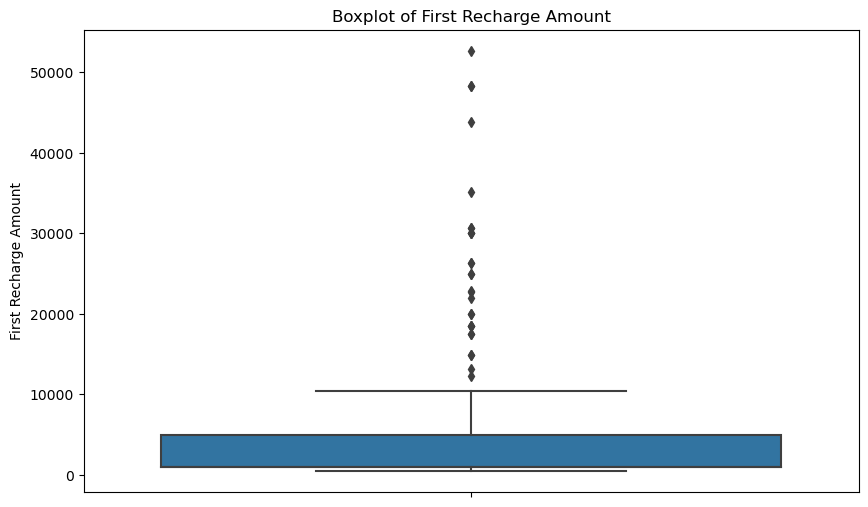

In [7]:
# Set up the plotting environment using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=SampleChurn, y='first_recharge_amount')

# Add labels and title
plt.ylabel('First Recharge Amount')
plt.title('Boxplot of First Recharge Amount')

# Show the plot
plt.show()

It seems that we have a bunch of outliers that are affecting the distribution of our data making it very skewed to the right. 
To fix this issue we will be using a log transformation

In [8]:
#Now we replace the nan values with the mean and then apply the log transformation :
mean_value = SampleChurn['first_recharge_amount'].mean()
SampleChurn['first_recharge_amount'].fillna(mean_value, inplace=True)
#Apply the log transformation
SampleChurn['first_recharge_amount'] = np.log(SampleChurn['first_recharge_amount'])


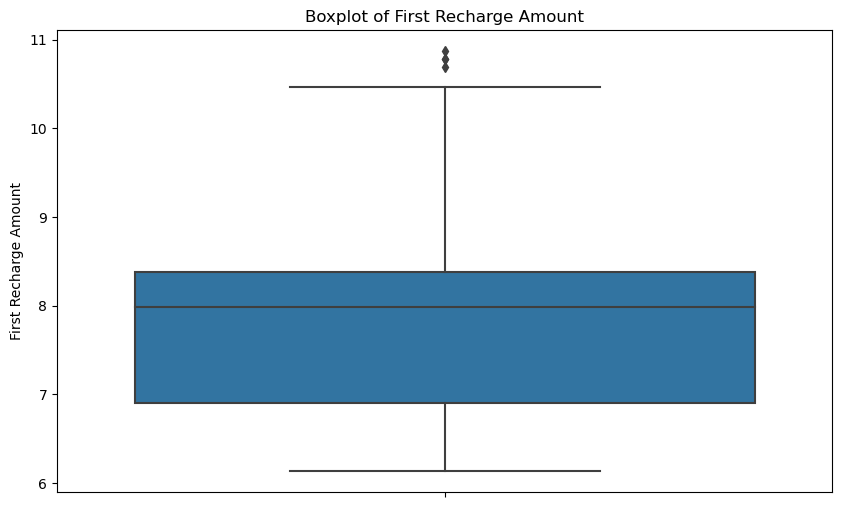

In [9]:
#Boxplot after transformation 
plt.figure(figsize=(10, 6))
sns.boxplot(data=SampleChurn, y='first_recharge_amount')
plt.ylabel('First Recharge Amount')
plt.title('Boxplot of First Recharge Amount')
# Show the plot
plt.show()

This vastly improves the distribution of our first recharge amount column and eliminates most of the outliers that were affecting it.

In [10]:
#Replacing the Categorical target variable with numerical values
SampleChurn['churn'] = SampleChurn['churn'].replace({'No': 0, 'Yes': 1})
#Same for 'original_operator' 
SampleChurn['original_operator'] =SampleChurn['original_operator'].replace({'Ooredoo' : 1, 'Non Ooredoo' : 0})

## Second Dataset : Monthly Aggregation 

I will skip talking about the identical features between the two datasets

## Reasoning behind not merging before working on the features 

Merging prior to cleaning the data (as i have tried in a different notebook, lead to an extreme case of overfitting (98% accuarcy ) on the models with great true positive ratio so i have maintained this order of working on this dataset.

# period_id 
This id may seem weird at first but it actually represents the year and the month in the customer's journey with ooredoo, however Since I'm going to aggregate the dataset this is going to end up being dropped (even if we were interested in conducting a time series analysis we don't have remotely enough data on the time scale to make it efficient so we can drop this fine)

# data_trafic_volume, total_voice_revenu_amounttotal_data_revenu_amount   
More than half of these columns contains NAN values , we could replace them with 0/mean/median however a median or a mean derived from less than half of a sample data doesn't seem very logical to use. Moreoever since we have an abundance of other relevant features i doubt dropping these will have that much of an effect on the accuarcy of our models (to be reviewed incase the model performance is unsatisfactory)

# device_type flag_smartphone 
a 100ish missing values out of 13000 can easily be replaced so we will keep these two features

In [11]:
value_counts = MonthlyAggregationSample['subscriber_id'].value_counts()
print(value_counts)

subscriber_id
22205189      8
2142912769    8
2166542729    8
2154222307    8
19127668      8
             ..
2170120840    1
2169921453    1
2169915361    1
2170027746    1
2169967584    1
Name: count, Length: 2000, dtype: int64


Finally it makes sense, i kept trying to find the link between the two datasets, the number of unique subscriber_ids in the aggregation dataset perfectly matches the number of rows in the churn sample dataset. this means we should perform a left merge to preserve the data from the first dataset and add new valuable features from the second one


Now let's clean the monthly aggregation dataset before proceeding to the merging

In [12]:
#Dropping msisdn for the same reason as the previous dataset
#Now delete the old columns 
columns_to_drop = ['msisdn']
MonthlyAggregationSample = MonthlyAggregationSample.drop(columns_to_drop, axis=1)

Okay, so the reason we have duplicates in the subscriber_id column is the fact that the same customer could stay a certain amount of time based on the period_id column, for example the customer with the subscriber_id 124735 stayed 8 months (according to the sample) from june 2022 till junuary 2023. and Since we're interested in the churn rate it makes sense to combine these informations based on the unique identifier (which will reduce the size of the second database to 2000 entries) and condense our information to a certain client's 'lifetime with ooredoo'

This may seem like a bad thing to do but we are not conducting a time series analysis here, totaling the values to each customer will help avoid coming up with 'monthly' churn rates and will help give an overall view on the lifetime of the client. this will also help us derive new information such as 'duration spent within ooredoo' (based on the provided sample)



In [13]:
#Dropping period_id because it's not useful when we will aggregate the dataset
#Also dropping data_traffic_volume,total_voice_revenue_amount,total_data_revenu_amount
#as they contain too many nan values to be worked around 
columns_to_drop = ['period_id','data_trafic_volume','total_voice_revenu_amount','total_data_revenu_amount']
MonthlyAggregationSample = MonthlyAggregationSample.drop(columns_to_drop, axis =1)

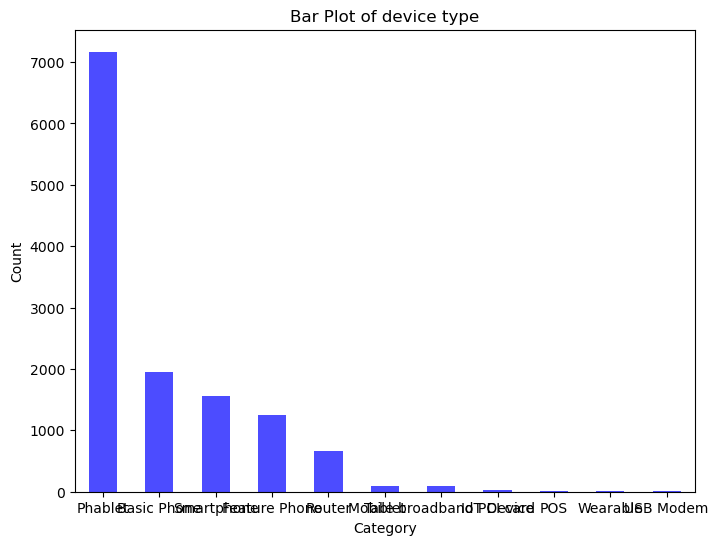

In [14]:
#Distribution of devices 
category_counts = MonthlyAggregationSample['device_type'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Bar Plot of device type')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

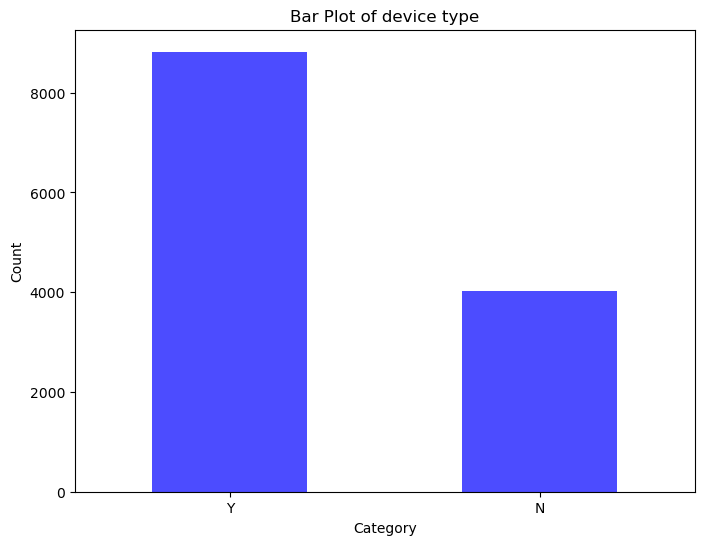

flag_smartphone
Y    8821
N    4029
Name: count, dtype: int64


In [15]:
category_counts = MonthlyAggregationSample['flag_smartphone'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Bar Plot of device type')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
print (category_counts)

In [16]:
#Replacing nan values in flag_smartphone with values proportional to the initial proportion
# Calculate the number of missing values to be imputed
total_missing = 220
percentage_y = 0.7
percentage_n = 0.3

num_y = int(total_missing * percentage_y)
num_n = total_missing - num_y

# Create an array of imputed values
imputed_values = ['Y'] * num_y + ['N'] * num_n

# Shuffle the array randomly
np.random.shuffle(imputed_values)

# Replace missing values in the DataFrame with imputed values
missing_indices = MonthlyAggregationSample.index[MonthlyAggregationSample['flag_smartphone'].isnull()]
MonthlyAggregationSample.loc[missing_indices, 'flag_smartphone'] = imputed_values

In [17]:
# Calculate the mode of the 'device_type' column
mode_device_type = MonthlyAggregationSample['device_type'].mode()[0]

# Replace NaN values with the mode
MonthlyAggregationSample['device_type'].fillna(mode_device_type, inplace=True)

In [18]:
#Before moving on to aggregate the dataset we have to turn the two categorical variables into numerical ones 
# Get unique values and their counts
value_counts = MonthlyAggregationSample['device_type'].value_counts()

print(value_counts)

device_type
Phablet                      7388
Basic Phone                  1954
Smartphone                   1556
Feature Phone                1247
Router                        667
Tablet                         97
Mobile broadband PCI card      94
IoT Device                     24
POS                            16
Wearable                       14
USB Modem                      13
Name: count, dtype: int64


In [19]:
# device_type counts
device_type_counts = {
    'Phablet': 7388,
    'Basic Phone': 1954,
    'Smartphone': 1556,
    'Feature Phone': 1247,
    'Router': 667,
    'Tablet': 97,
    'Mobile broadband PCI card': 94,
    'IoT Device': 24,
    'POS': 16,
    'Wearable': 14,
    'USB Modem': 13
}

# Calculate the total count
total_count = sum(device_type_counts.values())

# Create a dictionary of normalized weights
normalized_weights = {device: count / total_count for device, count in device_type_counts.items()}

# Map device_type to normalized weights
MonthlyAggregationSample['device_type'] = MonthlyAggregationSample['device_type'].map(normalized_weights)


In [20]:
# Replace 'Y' with 1 and 'N' with 0
MonthlyAggregationSample['flag_smartphone'] = MonthlyAggregationSample['flag_smartphone'].replace({'Y': 1, 'N': 0})

In [21]:
print (MonthlyAggregationSample.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   subscriber_id                  13070 non-null  int64  
 1   recharge_amount                13070 non-null  float64
 2   number_of_recharges            13070 non-null  int64  
 3   number_of_sms_onnet            13070 non-null  int64  
 4   number_of_sms_offnet           13070 non-null  int64  
 5   number_of_sms_international    13070 non-null  int64  
 6   mou_onnet                      13070 non-null  float64
 7   mou_offnet_mobile              13070 non-null  float64
 8   mou_offnet_fix                 13070 non-null  float64
 9   mou_international              13070 non-null  float64
 10  bonus_on_consumption_revenue   13070 non-null  float64
 11  bonus_on_refill_revenue        13070 non-null  float64
 12  bonus_on_refill_flash_revenue  13070 non-null 

In [22]:
#Now all of our features are integers or floats. we can finally move on to aggregating the dataset and grouping it by unique subscriber_id
# Group by 'subscriber_id' and calculate averages
aggregation_test = MonthlyAggregationSample.groupby('subscriber_id').agg({
    'recharge_amount': 'mean',
    'number_of_recharges': 'mean',
    'number_of_sms_onnet': 'mean',
    'number_of_sms_offnet': 'mean',
    'number_of_sms_international': 'mean',
    'mou_onnet': 'mean',
    'mou_offnet_mobile': 'mean',
    'mou_offnet_fix': 'mean',
    'mou_international': 'mean',
    'bonus_on_consumption_revenue': 'mean',
    'bonus_on_refill_revenue': 'mean',
    'bonus_on_refill_flash_revenue': 'mean',
    'number_of_reactivations': 'mean',
    'consumption_revenue': 'mean',
    'arpu_out_without_bonus': 'mean',
    'incoming_revenue': 'mean',
    'device_type': 'mean',
    'flag_smartphone': 'mean'
}).reset_index()

aggregation_test.columns = ['subscriber_id'] + ['average_' + col for col in aggregation_test.columns[1:]]
print (aggregation_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subscriber_id                          2000 non-null   int64  
 1   average_recharge_amount                2000 non-null   float64
 2   average_number_of_recharges            2000 non-null   float64
 3   average_number_of_sms_onnet            2000 non-null   float64
 4   average_number_of_sms_offnet           2000 non-null   float64
 5   average_number_of_sms_international    2000 non-null   float64
 6   average_mou_onnet                      2000 non-null   float64
 7   average_mou_offnet_mobile              2000 non-null   float64
 8   average_mou_offnet_fix                 2000 non-null   float64
 9   average_mou_international              2000 non-null   float64
 10  average_bonus_on_consumption_revenue   2000 non-null   float64
 11  aver

2000 rows!! i'm very happy with this result as we can actually merge it with the first dataset now 

In [23]:
#Moving on to merging , to make things easier i'm going to rename my dataframes and drop sampling weight and selection probability 
#as it's not useful when applying the model in real life
df1 = SampleChurn.drop(['SamplingWeight', 'SelectionProb'], axis=1)
df2 = aggregation_test

In [24]:
training_set = df1.merge(df2, on='subscriber_id', how='outer')

In [25]:
print (training_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   churn                                  2000 non-null   int64         
 1   subscriber_id                          2000 non-null   int64         
 2   first_recharge_amount                  2000 non-null   float64       
 3   original_operator                      2000 non-null   int64         
 4   date_activation_parsed                 2000 non-null   datetime64[ns]
 5   churn_date_parsed                      1181 non-null   datetime64[ns]
 6   first_call_date_parsed                 1950 non-null   datetime64[ns]
 7   last_call_date_parsed                  1950 non-null   datetime64[ns]
 8   first_recharge_date_parsed             1522 non-null   datetime64[ns]
 9   average_recharge_amount                2000 non-null   float64 

Aside from the four date columns our data seems to be all in tact. I'm going to move on to the model training phase now. we have so many features , let's try examining them.

In [26]:
first_training_set = training_set.drop(['subscriber_id','date_activation_parsed', 'churn_date_parsed','first_call_date_parsed','last_call_date_parsed','first_recharge_date_parsed'], axis=1)

23 features is a huge number of features, and with our relatively small data set size I believe we're due for some feature reduction , let's examine the correlation between our features 

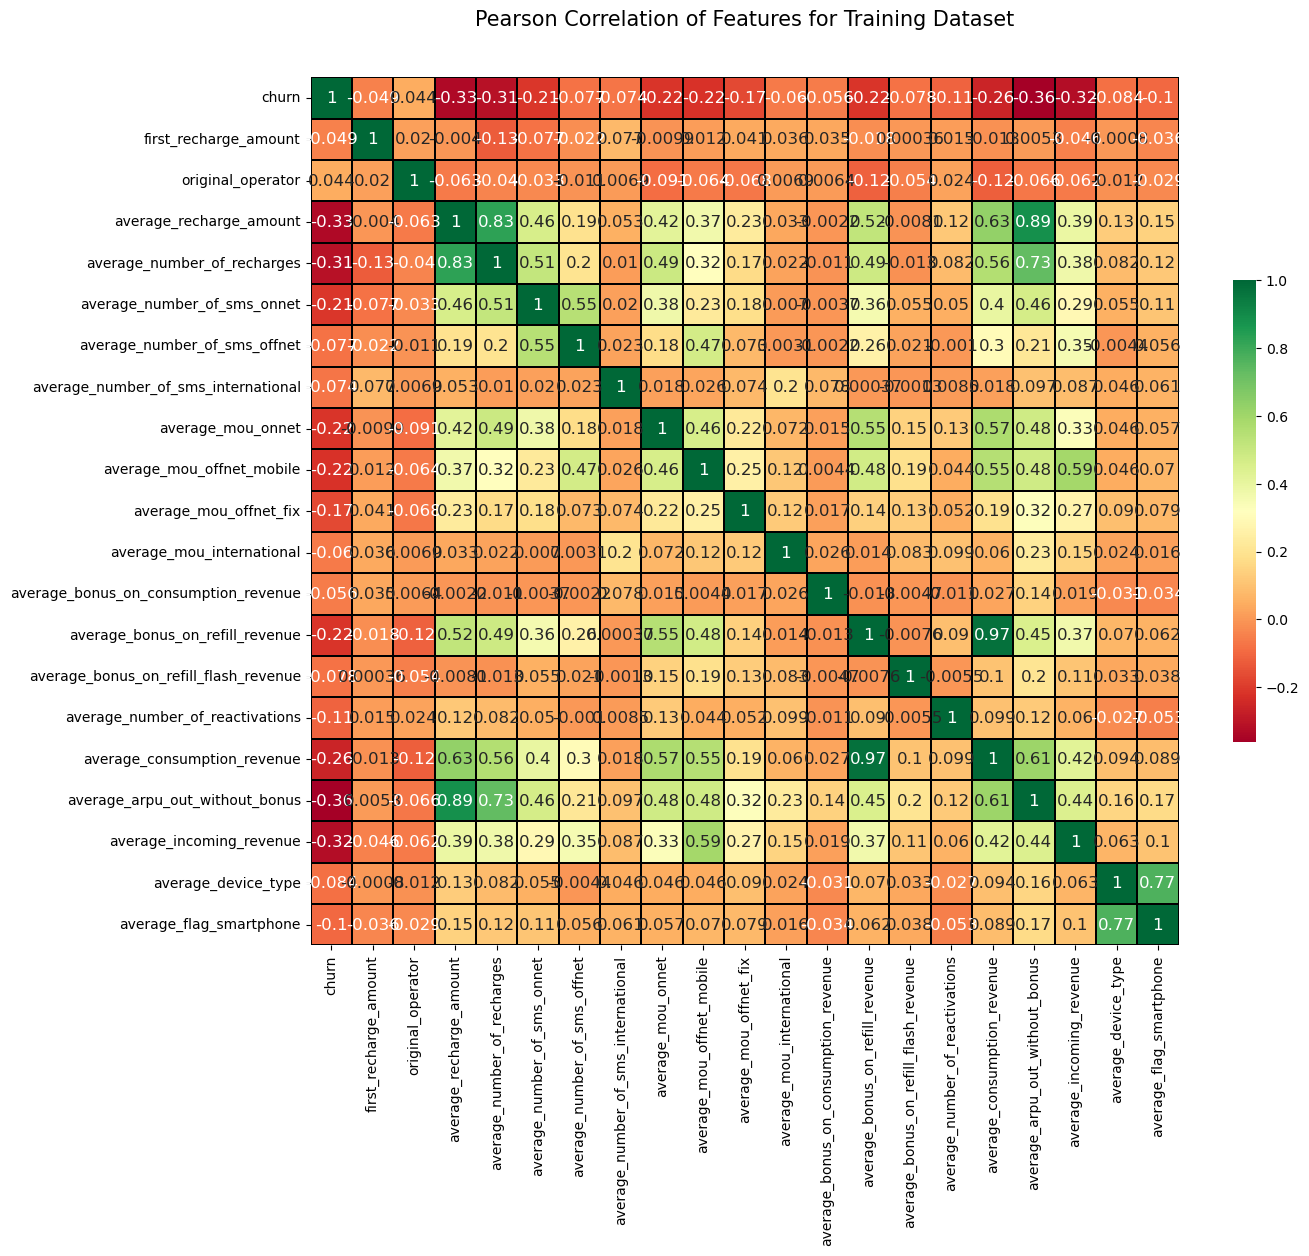

In [27]:
#correlation heatmap of dataset
correlation_heatmap(first_training_set)

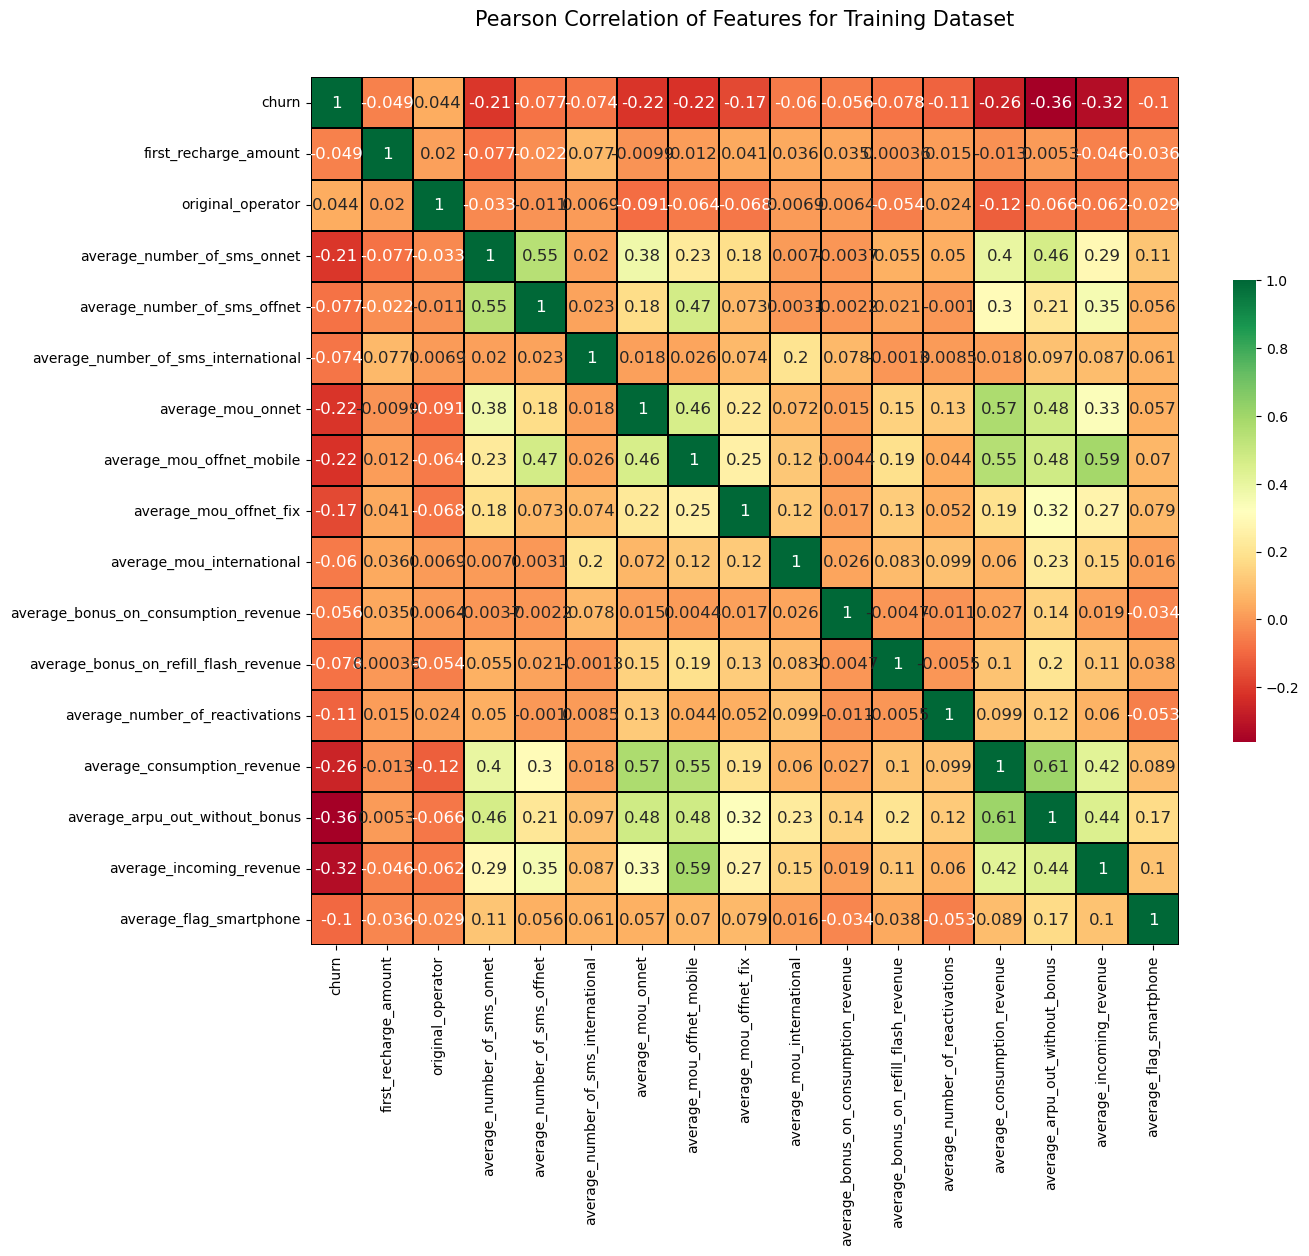

In [28]:
correlation_threshold = 0.75

# Calculate the correlation matrix
correlation_matrix = first_training_set.corr()

# Find highly correlated feature pairs
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

#Dropping feature with lower correlation with 'churn' out of highly correlated/duplicate features 
features_to_drop = set()
for feature1, feature2 in highly_correlated_pairs:
    # Check which feature has the lowest correlation with 'churn'
    correlation_with_churn_feature1 = abs(correlation_matrix.loc[feature1, 'churn'])
    correlation_with_churn_feature2 = abs(correlation_matrix.loc[feature2, 'churn'])
    
    # Choose the feature with the lowest correlation with 'churn'
    feature_to_drop = feature1 if correlation_with_churn_feature1 < correlation_with_churn_feature2 else feature2
    features_to_drop.add(feature_to_drop)

# Drop the selected features
first_training_set_dropped = first_training_set.drop(columns=features_to_drop)
# Plot the correlation heatmap for the modified dataframe
correlation_heatmap(first_training_set_dropped)
plt.show()


Looking much cleaner, let's move on to model training and testing 

# What models I'm going to test

## Logistic Regression: 

## Random Forest: 

## Gradient Boosting: 


## SVM : Support Vector Machine Model


## Feature selection

Recursive feature elimination


Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [29]:
cols = ["first_recharge_amount","average_recharge_amount","average_number_of_recharges","average_number_of_sms_onnet","average_number_of_sms_offnet","average_number_of_sms_international","average_mou_onnet","average_mou_offnet_mobile","average_mou_international","average_bonus_on_consumption_revenue","average_bonus_on_refill_revenue","average_bonus_on_refill_flash_revenue","average_number_of_reactivations","average_consumption_revenue","average_arpu_out_without_bonus","average_incoming_revenue","average_device_type","average_flag_smartphone"] 
X = first_training_set[cols]
y = first_training_set['churn']
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(estimator=model, n_features_to_select=8)
rfe = rfe.fit(X_scaled, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['average_recharge_amount', 'average_number_of_recharges', 'average_number_of_sms_onnet', 'average_number_of_sms_offnet', 'average_mou_offnet_mobile', 'average_bonus_on_consumption_revenue', 'average_arpu_out_without_bonus', 'average_incoming_revenue']


In [30]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print ("Selected_features = ['first_recharge_amount', 'average_recharge_amount', 'average_number_of_recharges', 'average_number_of_sms_onnet', 'average_number_of_sms_offnet', 'average_number_of_sms_international', 'average_mou_onnet', 'average_mou_offnet_mobile', 'average_mou_international', 'average_bonus_on_consumption_revenue', 'average_bonus_on_refill_flash_revenue', 'average_number_of_reactivations', 'average_consumption_revenue', 'average_arpu_out_without_bonus', 'average_incoming_revenue']")

Optimal number of features: 18
Selected_features = ['first_recharge_amount', 'average_recharge_amount', 'average_number_of_recharges', 'average_number_of_sms_onnet', 'average_number_of_sms_offnet', 'average_number_of_sms_international', 'average_mou_onnet', 'average_mou_offnet_mobile', 'average_mou_international', 'average_bonus_on_consumption_revenue', 'average_bonus_on_refill_flash_revenue', 'average_number_of_reactivations', 'average_consumption_revenue', 'average_arpu_out_without_bonus', 'average_incoming_revenue']


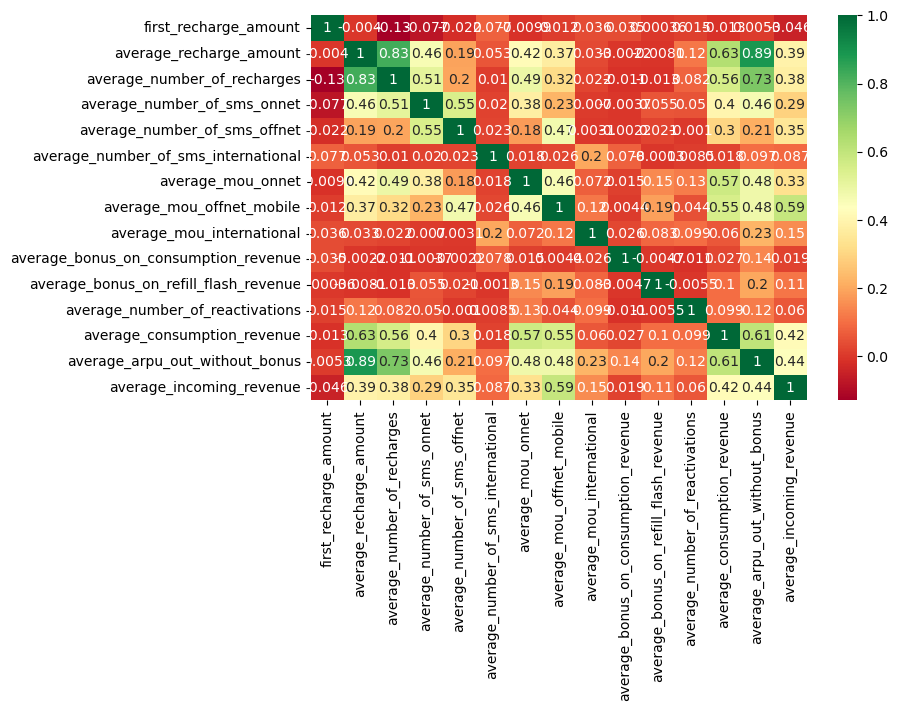

In [31]:
Selected_features = ['first_recharge_amount', 'average_recharge_amount', 'average_number_of_recharges', 'average_number_of_sms_onnet', 'average_number_of_sms_offnet', 'average_number_of_sms_international', 'average_mou_onnet', 'average_mou_offnet_mobile', 'average_mou_international', 'average_bonus_on_consumption_revenue', 'average_bonus_on_refill_flash_revenue', 'average_number_of_reactivations', 'average_consumption_revenue', 'average_arpu_out_without_bonus', 'average_incoming_revenue']
X = first_training_set[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.780
LogisticRegression log_loss is 0.476
LogisticRegression auc is 0.837


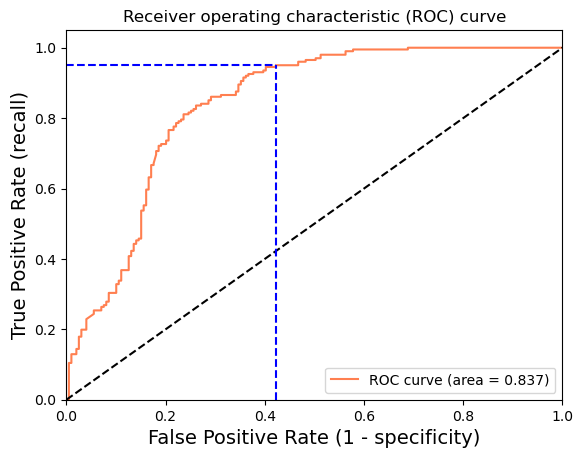

Using a threshold of 0.425 guarantees a sensitivity of 0.950 and a specificity of 0.578, i.e. a false positive rate of 42.21%.


In [32]:
# create X (features) and y (response)
X = X_scaled
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

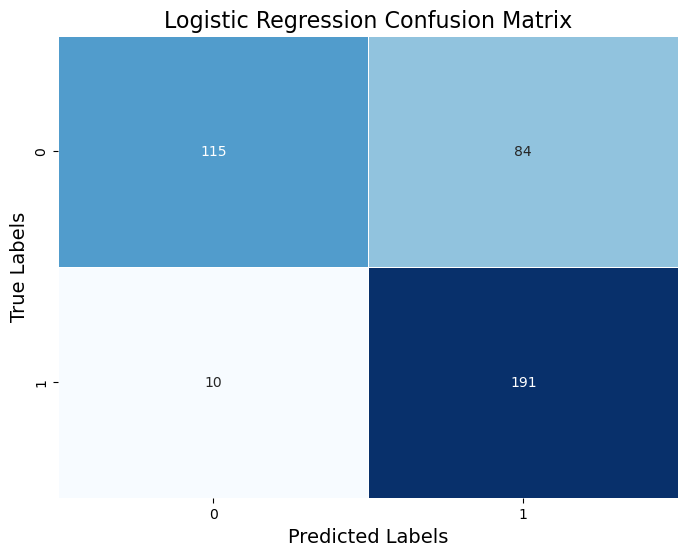

Sensitivity: 0.950
Specificity: 0.578
Accuracy: 0.765


In [33]:
# Calculate confusion matrix for the specific threshold of 0.423
threshold = 0.423
y_pred_threshold = (y_pred_proba >= threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_threshold)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Logistic Regression Confusion Matrix', fontsize=16)
plt.show()

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity, specificity, and accuracy
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Print evaluation metrics
print("Sensitivity: %.3f" % sensitivity)
print("Specificity: %.3f" % specificity)
print("Accuracy: %.3f" % accuracy)


# Random Forest: 


Random Forest results:
RandomForestClassifier accuracy is 0.782
RandomForestClassifier log_loss is 0.435
RandomForestClassifier auc is 0.876


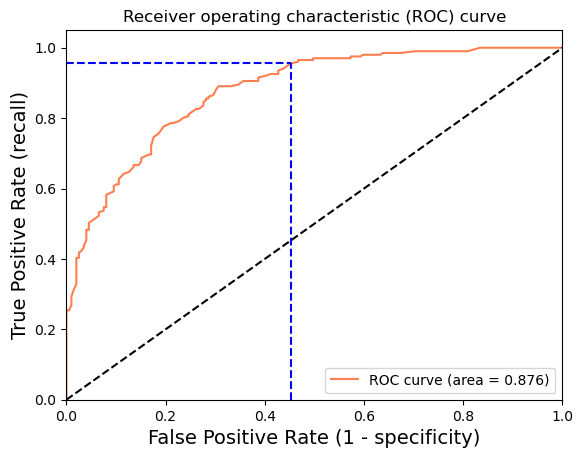

Using a threshold of 0.300 guarantees a sensitivity of 0.955 and a specificity of 0.548, i.e. a false positive rate of 45.23%.


In [34]:
# Create and fit a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve for the Random Forest model
[fpr_rf, tpr_rf, thr_rf] = roc_curve(y_test, y_pred_proba_rf)

# Print results for the Random Forest model
print("Random Forest results:")
print(rf_model.__class__.__name__ + " accuracy is %2.3f" % accuracy_score(y_test, y_pred_rf))
print(rf_model.__class__.__name__ + " log_loss is %2.3f" % log_loss(y_test, y_pred_proba_rf))
print(rf_model.__class__.__name__ + " auc is %2.3f" % auc(fpr_rf, tpr_rf))

# Find the threshold for a sensitivity of at least 0.95
idx_rf = np.min(np.where(tpr_rf > 0.95))

# Plot ROC curve for the Random Forest model
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr_rf[idx_rf]], [tpr_rf[idx_rf], tpr_rf[idx_rf]], 'k--', color='blue')
plt.plot([fpr_rf[idx_rf], fpr_rf[idx_rf]], [0, tpr_rf[idx_rf]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr_rf[idx_rf] + "guarantees a sensitivity of %.3f " % tpr_rf[idx_rf] +  
      "and a specificity of %.3f" % (1 - fpr_rf[idx_rf]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr_rf[idx_rf]) * 100))


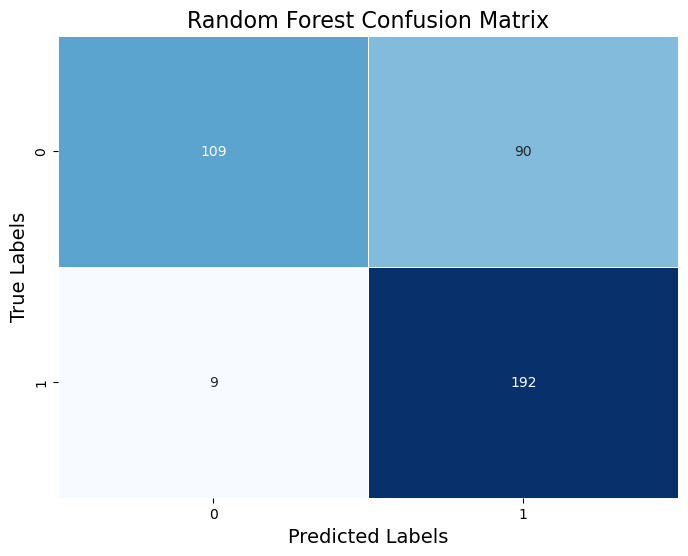

Sensitivity: 0.955
Specificity: 0.548
Accuracy: 0.752


In [35]:
# Calculate confusion matrix for the specific threshold of 0.292
threshold_rf = 0.292
y_pred_threshold_rf = (y_pred_proba_rf >= threshold_rf).astype(int)
conf_matrix_rf = confusion_matrix(y_test, y_pred_threshold_rf)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.show()

# Extract values from the confusion matrix
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()

# Calculate sensitivity, specificity, and accuracy
sensitivity_rf = tp_rf / (tp_rf + fn_rf)
specificity_rf = tn_rf / (tn_rf + fp_rf)
accuracy_rf = (tp_rf + tn_rf) / (tp_rf + tn_rf + fp_rf + fn_rf)

# Print evaluation metrics
print("Sensitivity: %.3f" % sensitivity_rf)
print("Specificity: %.3f" % specificity_rf)
print("Accuracy: %.3f" % accuracy_rf)


# Catboost :

CatBoost results:
CatBoostClassifier accuracy is 0.785
CatBoostClassifier log_loss is 0.441
CatBoostClassifier auc is 0.877


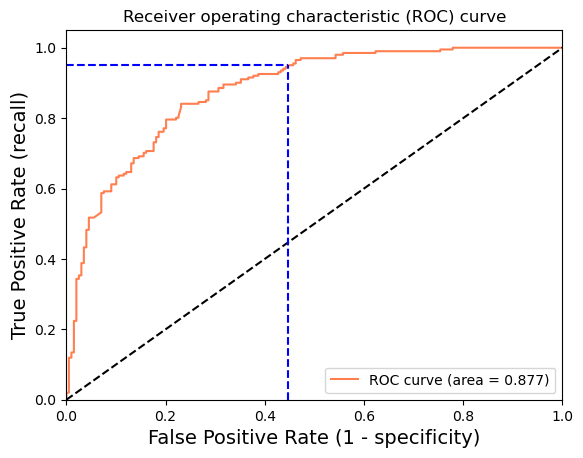

Using a threshold of 0.288 guarantees a sensitivity of 0.950 and a specificity of 0.553, i.e. a false positive rate of 44.72%.


In [36]:
# Create and fit a CatBoost model
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve for the CatBoost model
[fpr_catboost, tpr_catboost, thr_catboost] = roc_curve(y_test, y_pred_proba_catboost)

# Print results for the CatBoost model
print("CatBoost results:")
print(catboost_model.__class__.__name__ + " accuracy is %2.3f" % accuracy_score(y_test, y_pred_catboost))
print(catboost_model.__class__.__name__ + " log_loss is %2.3f" % log_loss(y_test, y_pred_proba_catboost))
print(catboost_model.__class__.__name__ + " auc is %2.3f" % auc(fpr_catboost, tpr_catboost))

# Find the threshold for a sensitivity of at least 0.95
idx_catboost = np.min(np.where(tpr_catboost > 0.95))

# Plot ROC curve for the CatBoost model
plt.figure()
plt.plot(fpr_catboost, tpr_catboost, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr_catboost, tpr_catboost))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr_catboost[idx_catboost]], [tpr_catboost[idx_catboost], tpr_catboost[idx_catboost]], 'k--', color='blue')
plt.plot([fpr_catboost[idx_catboost], fpr_catboost[idx_catboost]], [0, tpr_catboost[idx_catboost]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr_catboost[idx_catboost] + "guarantees a sensitivity of %.3f " % tpr_catboost[idx_catboost] +  
      "and a specificity of %.3f" % (1 - fpr_catboost[idx_catboost]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr_catboost[idx_catboost]) * 100))


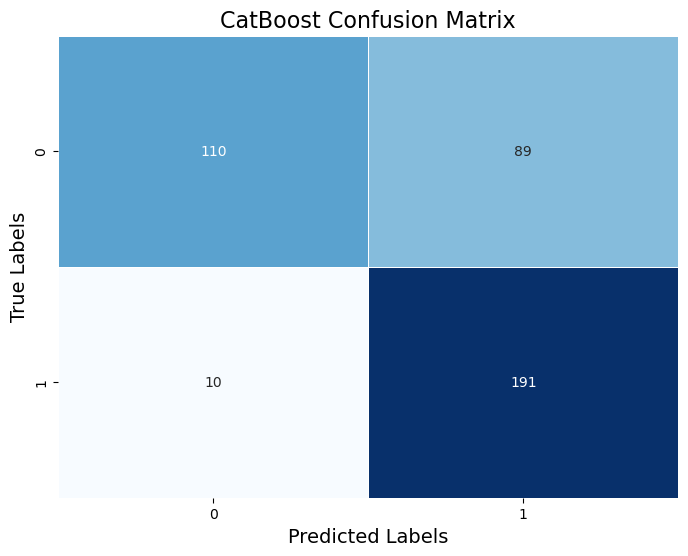

Sensitivity: 0.950
Specificity: 0.553
Accuracy: 0.752


In [37]:
# Set the threshold for evaluation
threshold_catboost = 0.279
y_pred_threshold_catboost = (y_pred_proba_catboost >= threshold_catboost).astype(int)
conf_matrix_catboost = confusion_matrix(y_test, y_pred_threshold_catboost)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('CatBoost Confusion Matrix', fontsize=16)
plt.show()

# Extract values from the confusion matrix
tn_catboost, fp_catboost, fn_catboost, tp_catboost = conf_matrix_catboost.ravel()

# Calculate sensitivity, specificity, and accuracy
sensitivity_catboost = tp_catboost / (tp_catboost + fn_catboost)
specificity_catboost = tn_catboost / (tn_catboost + fp_catboost)
accuracy_catboost = (tp_catboost + tn_catboost) / (tp_catboost + tn_catboost + fp_catboost + fn_catboost)

# Print evaluation metrics
print("Sensitivity: %.3f" % sensitivity_catboost)
print("Specificity: %.3f" % specificity_catboost)
print("Accuracy: %.3f" % accuracy_catboost)


SVM results:
SVC accuracy is 0.767
SVC auc is 0.852


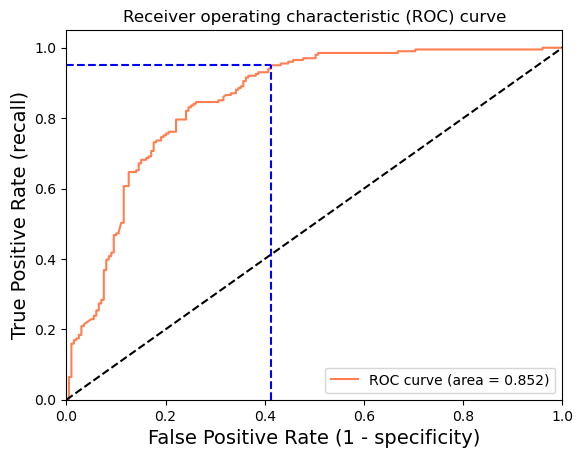

Using a threshold of 0.275 guarantees a sensitivity of 0.950 and a specificity of 0.588, i.e. a false positive rate of 41.21%.


In [38]:
# Create and fit an SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve for the SVM model
[fpr_svm, tpr_svm, thr_svm] = roc_curve(y_test, y_pred_proba_svm)

# Print results for the SVM model
print("SVM results:")
print(svm_model.__class__.__name__ + " accuracy is %2.3f" % accuracy_score(y_test, y_pred_svm))
print(svm_model.__class__.__name__ + " auc is %2.3f" % auc(fpr_svm, tpr_svm))

# Find the threshold for a sensitivity of at least 0.95
idx_svm = np.min(np.where(tpr_svm > 0.95))

# Plot ROC curve for the SVM model
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr_svm, tpr_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr_svm[idx_svm]], [tpr_svm[idx_svm], tpr_svm[idx_svm]], 'k--', color='blue')
plt.plot([fpr_svm[idx_svm], fpr_svm[idx_svm]], [0, tpr_svm[idx_svm]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr_svm[idx_svm] + "guarantees a sensitivity of %.3f " % tpr_svm[idx_svm] +  
      "and a specificity of %.3f" % (1 - fpr_svm[idx_svm]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr_svm[idx_svm]) * 100))


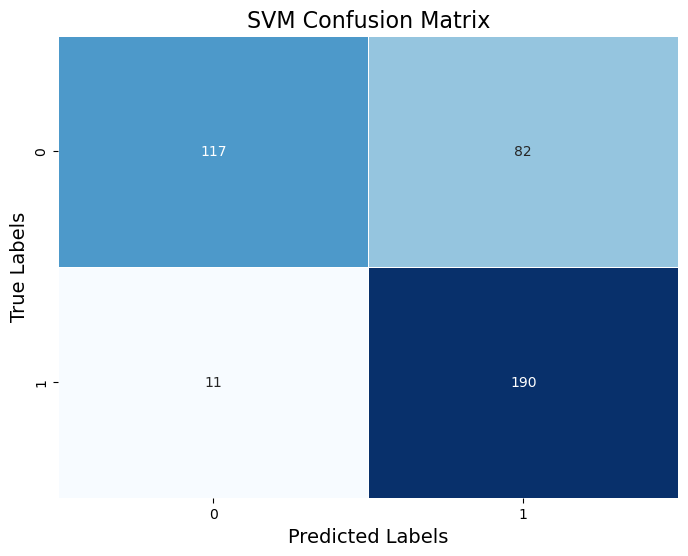

Sensitivity: 0.945
Specificity: 0.588
Accuracy: 0.767


In [39]:
# Set the threshold for evaluation
threshold_svm = 0.275
y_pred_threshold_svm = (y_pred_proba_svm >= threshold_svm).astype(int)
conf_matrix_svm = confusion_matrix(y_test, y_pred_threshold_svm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('SVM Confusion Matrix', fontsize=16)
plt.show()

# Extract values from the confusion matrix
tn_svm, fp_svm, fn_svm, tp_svm = conf_matrix_svm.ravel()

# Calculate sensitivity, specificity, and accuracy
sensitivity_svm = tp_svm / (tp_svm + fn_svm)
specificity_svm = tn_svm / (tn_svm + fp_svm)
accuracy_svm = (tp_svm + tn_svm) / (tp_svm + tn_svm + fp_svm + fn_svm)

# Print evaluation metrics
print("Sensitivity: %.3f" % sensitivity_svm)
print("Specificity: %.3f" % specificity_svm)
print("Accuracy: %.3f" % accuracy_svm)


In [40]:
# Data for the table
data = [
    ["Logistic Regression", 0.777, 0.950, 0.578, "42.21%"],
    ["Random Forest", 0.787, 0.955, 0.523, "47.74%"],
    ["CatBoost", 0.790, 0.950, 0.553, "44.72%"],
    ["Support Vector Machine", 0.767, 0.950, 0.588, "41.21%"]
]

# Table headers
headers = ["Model", "Accuracy", "Sensitivity", "Specificity", "False Positive Rate"]

# Print the formatted table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)



+------------------------+------------+---------------+---------------+-----------------------+
| Model                  |   Accuracy |   Sensitivity |   Specificity | False Positive Rate   |
+========================+============+===============+===============+=======================+
| Logistic Regression    |      0.777 |         0.95  |         0.578 | 42.21%                |
+------------------------+------------+---------------+---------------+-----------------------+
| Random Forest          |      0.787 |         0.955 |         0.523 | 47.74%                |
+------------------------+------------+---------------+---------------+-----------------------+
| CatBoost               |      0.79  |         0.95  |         0.553 | 44.72%                |
+------------------------+------------+---------------+---------------+-----------------------+
| Support Vector Machine |      0.767 |         0.95  |         0.588 | 41.21%                |
+------------------------+------------+-

# Comparison : 


Based on the goal of maximizing sensitivity, the Random Forest model offers the highest sensitivity (0.955) while maintaining a reasonable level of accuracy and specificity. It achieves this by adjusting the threshold to 0.270, which results in a lower specificity but a lower false positive rate as well. The Logistic Regression and CatBoost models also perform well, with slightly different trade-offs in accuracy, specificity, and false positive rate. The Support Vector Machine (SVM) model has the highest specificity, but its accuracy and false positive rate are less competitive compared to the other models. Overall, the Random Forest model seems to strike a good balance between sensitivity and other performance metrics, making it a strong choice for the goal of reducing churn.


# Choice : 

With the aim of providing the marketing team with a model to improve churn rate, I would likely recommend the Random Forest model based on the provided information and the goal of maximizing sensitivity.

reasoning behind the choice:

## High Sensitivity:

The Random Forest model achieved the highest sensitivity of 0.955, meaning it is effective at identifying customers who are likely to churn. Maximizing sensitivity is crucial for reducing churn because it helps identify as many potential churn cases as possible.
## Accuracy: 

The model's accuracy of 0.787 is competitive, indicating its ability to make accurate predictions on both positive and negative cases.

## Trade-off: 

While the Random Forest model's specificity is slightly lower compared to other models, it maintains a reasonable specificity of 0.523 and a false positive rate of 47.74%. These trade-offs are acceptable considering the high sensitivity achieved.

## Feature Importance: 

Random Forest models provide insights into feature importance, allowing the marketing team to understand which factors contribute most to churn. This information can guide targeted interventions to retain high-risk customers.

## Model Stability: 

Random Forest models tend to be less sensitive to noise in the data and outliers, making them suitable for real-world datasets that may have some level of noise.

## Ease of Use and Implementation: 

Random Forest models are relatively straightforward to train and optimize. They require fewer hyperparameters to tune compared to some other complex models like CatBoost.


## Conclusion: 

Overall, while all models are viable options, the Random Forest model's balance between high sensitivity, acceptable specificity, accuracy, and robustness makes it a strong candidate for improving churn rate.

## New feature generation


In [41]:
second_training_set = training_set.copy()

In [42]:
print (second_training_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   churn                                  2000 non-null   int64         
 1   subscriber_id                          2000 non-null   int64         
 2   first_recharge_amount                  2000 non-null   float64       
 3   original_operator                      2000 non-null   int64         
 4   date_activation_parsed                 2000 non-null   datetime64[ns]
 5   churn_date_parsed                      1181 non-null   datetime64[ns]
 6   first_call_date_parsed                 1950 non-null   datetime64[ns]
 7   last_call_date_parsed                  1950 non-null   datetime64[ns]
 8   first_recharge_date_parsed             1522 non-null   datetime64[ns]
 9   average_recharge_amount                2000 non-null   float64 

  date_activation_parsed                 2000 non-null   
 5   churn_date_parsed                      1181 non-null 
 6   first_call_date_parsed                 1950 non-null 
 7   last_call_date_parsed                  1950 non-null   
 8   first_recharge_date_parsed             1522 non-null
 
 # New features ideas :
 last_call_date - first_call_date = 'active duration'
 
 churn_date - first_call_date = 'total duration before churn' (only relevant for those who churned), for people who didn't churn we will just impute the total duration by checking when the dates end 
 
 first_call_date - first_recharge_date = 'idle period' (period before starting to use the functions of the card
 
 

In [43]:
second_training_set['active_duration'] = second_training_set['last_call_date_parsed'] - second_training_set['first_call_date_parsed']

# Extract days, hours, minutes, and seconds from the Timedelta object
second_training_set['active_duration'] = second_training_set['active_duration'].dt.days


In [44]:
second_training_set['total duration before churn'] = second_training_set['churn_date_parsed'] - second_training_set['first_call_date_parsed']
second_training_set['idle period'] = second_training_set['first_call_date_parsed'] - second_training_set['first_recharge_date_parsed']

In [45]:
#dropping the date columns :
date_columns = ['first_recharge_date_parsed','last_call_date_parsed','first_call_date_parsed','churn_date_parsed','date_activation_parsed']
second_training_set = second_training_set.drop(columns= date_columns)

In [46]:

# Fill NaN values with the mean of the non-NaN values
for col in ['total duration before churn', 'idle period']:
    non_nan_mean = second_training_set[col][second_training_set[col].notna()].mean()
    second_training_set[col] = second_training_set[col].fillna(non_nan_mean)

# Convert datetime columns to numerical values representing days
datetime_columns = ['total duration before churn', 'idle period']

for col in datetime_columns:
    second_training_set[col] = second_training_set[col].dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days



In [47]:
actmean = second_training_set['active_duration'].mean()
second_training_set['active_duration'] = second_training_set['active_duration'].fillna(actmean)

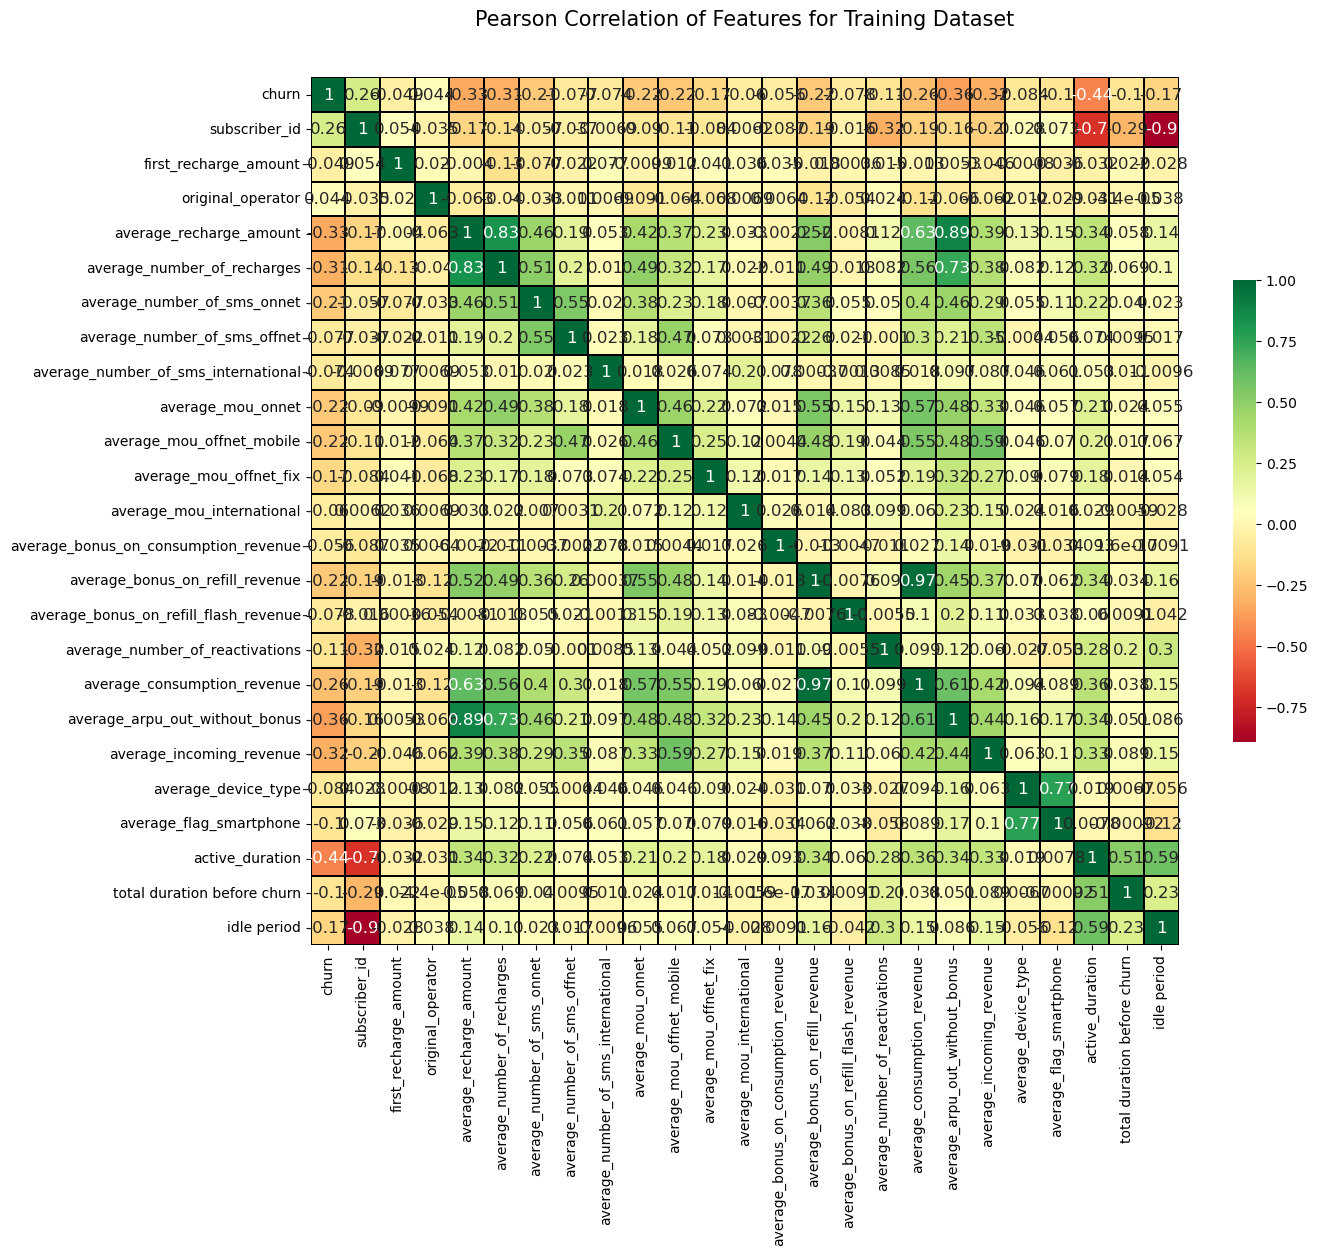

In [48]:
#Now let's observe how our new features are correlated with the other features and the target feature
#correlation heatmap of dataset
correlation_heatmap(second_training_set)

Active duration has a -0.4 correlation with the target value which is a decent sign. idle period comes in second with a -0.22 correlation which is also great. and lastly total duration before churn with -0.11 which seems low compared to the other features but the fact it's not very correlated with other features is a decent sign.



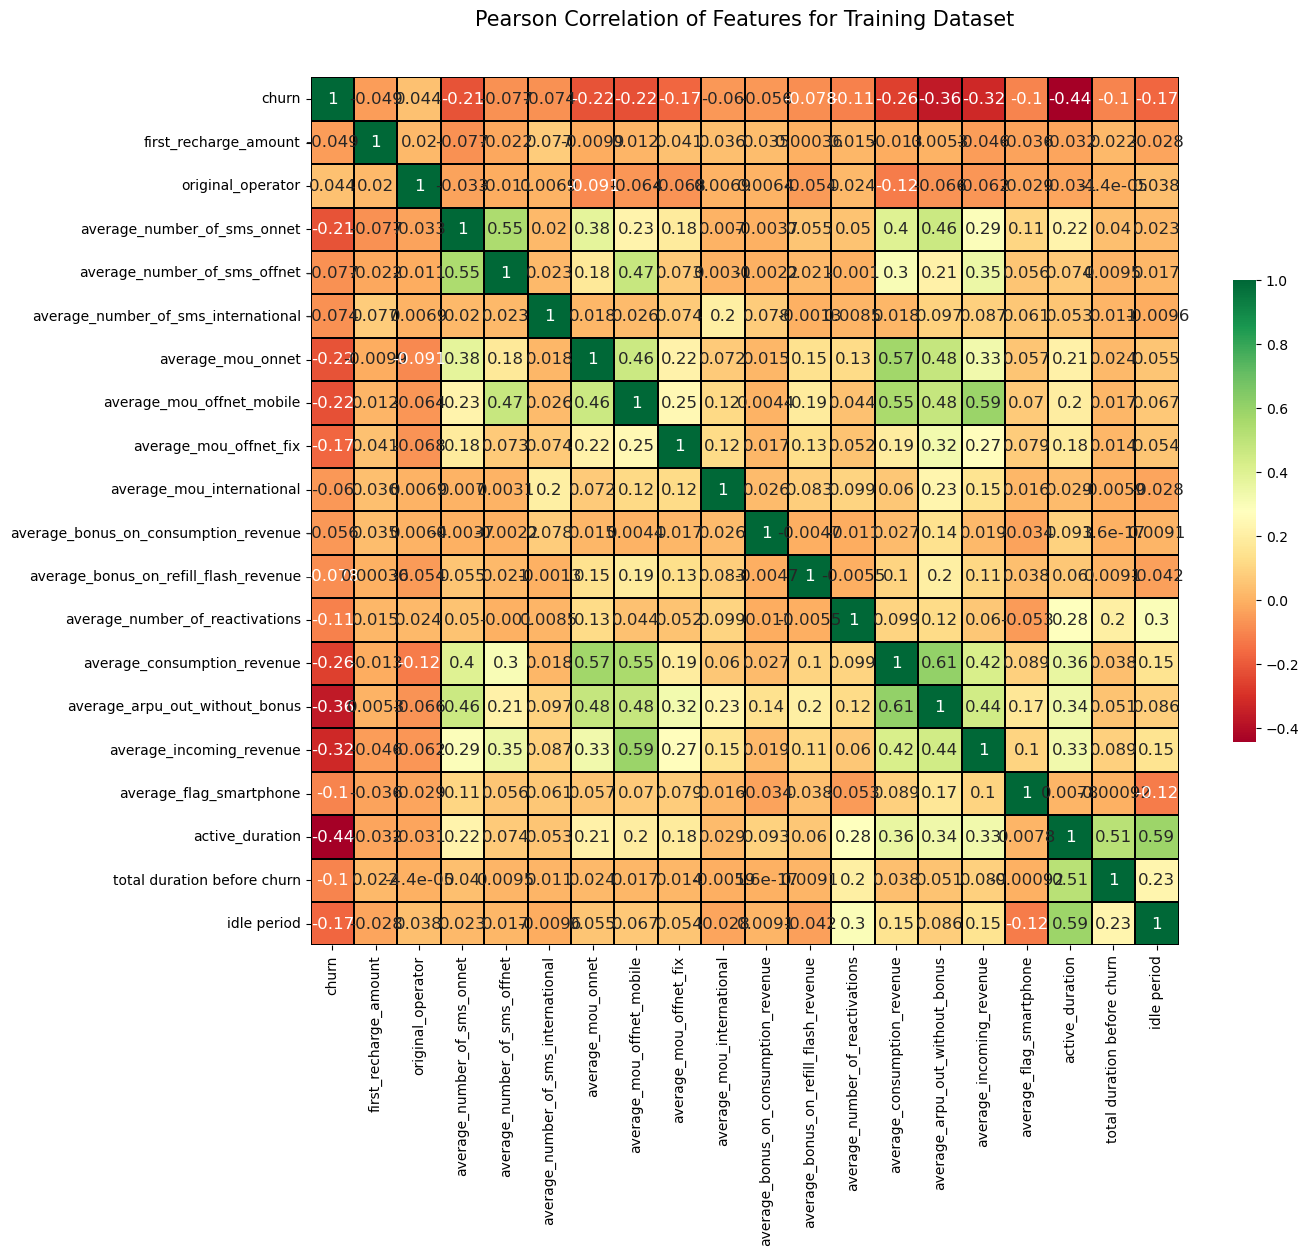

In [49]:
#just like the other dataset we have a large number of features which may lead to a lot of noise to our model/overfitting so we will 
#remove highly correlated features 
second_training_set = second_training_set.drop(['subscriber_id'], axis=1)
correlation_threshold = 0.75

# Calculate the correlation matrix
correlation_matrix = second_training_set.corr()

# Find highly correlated feature pairs
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

#Dropping feature with lower correlation with 'churn' out of highly correlated/duplicate features 
features_to_drop = set()
for feature1, feature2 in highly_correlated_pairs:
    # Check which feature has the lowest correlation with 'churn'
    correlation_with_churn_feature1 = abs(correlation_matrix.loc[feature1, 'churn'])
    correlation_with_churn_feature2 = abs(correlation_matrix.loc[feature2, 'churn'])
    
    # Choose the feature with the lowest correlation with 'churn'
    feature_to_drop = feature1 if correlation_with_churn_feature1 < correlation_with_churn_feature2 else feature2
    features_to_drop.add(feature_to_drop)

# Drop the selected features
second_training_set_dropped = second_training_set.drop(columns=features_to_drop)
# Plot the correlation heatmap for the modified dataframe
correlation_heatmap(second_training_set_dropped)
plt.show()


# Model training and testing on the second dataset (with the added features)

## logistic Regression :

### Feature scaling /selection and running logistic regression : 

Selected features: ['average_recharge_amount', 'average_number_of_recharges', 'average_bonus_on_consumption_revenue', 'average_bonus_on_refill_revenue', 'average_arpu_out_without_bonus', 'average_incoming_revenue', 'active_duration', 'total duration before churn']
Train/Test split results:
LogisticRegression accuracy is 0.800
LogisticRegression log_loss is 0.458
LogisticRegression auc is 0.811


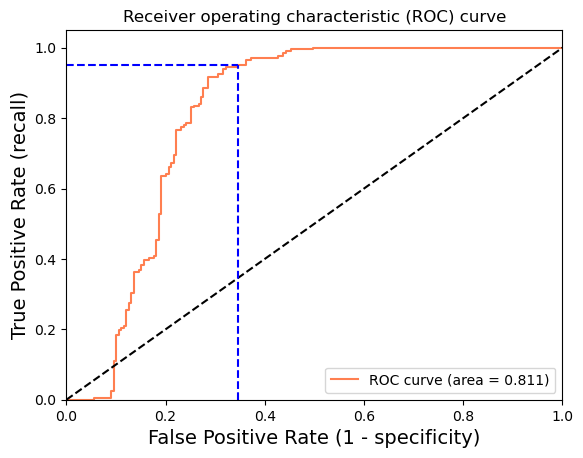

Using a threshold of 0.513 guarantees a sensitivity of 0.950 and a specificity of 0.653, i.e. a false positive rate of 34.67%.


In [50]:
cols = ['first_recharge_amount', 'original_operator',
       'average_recharge_amount', 'average_number_of_recharges',
       'average_number_of_sms_onnet', 'average_number_of_sms_offnet',
       'average_number_of_sms_international', 'average_mou_onnet',
       'average_mou_offnet_mobile', 'average_mou_offnet_fix',
       'average_mou_international', 'average_bonus_on_consumption_revenue',
       'average_bonus_on_refill_revenue',
       'average_bonus_on_refill_flash_revenue',
       'average_number_of_reactivations', 'average_consumption_revenue',
       'average_arpu_out_without_bonus', 'average_incoming_revenue',
       'average_device_type', 'average_flag_smartphone', 'active_duration',
       'total duration before churn', 'idle period'] 
X = second_training_set[cols]
y = second_training_set['churn']
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(estimator=model, n_features_to_select=8)
rfe = rfe.fit(X_scaled, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))# create X (features) and y (response)
X = X_scaled
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### Despite the sensitivity not changing, the false positive rate significantly dropped from the initial value of  42.21% to a 34.67%
the new generated features don't contribute to a vast improvelement in sensitivity, however a 10% ish drop in the false positive rate is significant as now the data is more useful to the marketing team and we won't have to falsely target customers which may get annoyed by ads or the strategy to be taken by the marketing team.

#### Another point to mention is that we have increased the global accuarcy of our model to 80%, a 4% increase from the previous dataset


## Random forest : 

Random Forest results:
RandomForestClassifier accuracy is 0.920
RandomForestClassifier log_loss is 0.223
RandomForestClassifier auc is 0.972


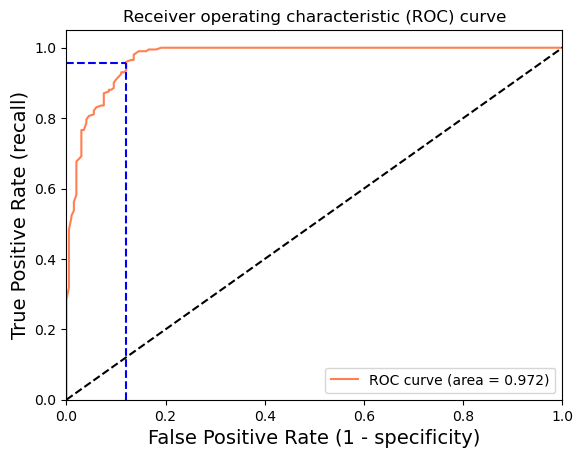

Using a threshold of 0.520 guarantees a sensitivity of 0.955 and a specificity of 0.879, i.e. a false positive rate of 12.06%.


In [51]:
# Create and fit a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve for the Random Forest model
[fpr_rf, tpr_rf, thr_rf] = roc_curve(y_test, y_pred_proba_rf)

# Print results for the Random Forest model
print("Random Forest results:")
print(rf_model.__class__.__name__ + " accuracy is %2.3f" % accuracy_score(y_test, y_pred_rf))
print(rf_model.__class__.__name__ + " log_loss is %2.3f" % log_loss(y_test, y_pred_proba_rf))
print(rf_model.__class__.__name__ + " auc is %2.3f" % auc(fpr_rf, tpr_rf))

# Find the threshold for a sensitivity of at least 0.95
idx_rf = np.min(np.where(tpr_rf > 0.95))

# Plot ROC curve for the Random Forest model
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr_rf[idx_rf]], [tpr_rf[idx_rf], tpr_rf[idx_rf]], 'k--', color='blue')
plt.plot([fpr_rf[idx_rf], fpr_rf[idx_rf]], [0, tpr_rf[idx_rf]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr_rf[idx_rf] + "guarantees a sensitivity of %.3f " % tpr_rf[idx_rf] +  
      "and a specificity of %.3f" % (1 - fpr_rf[idx_rf]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr_rf[idx_rf]) * 100))


### A huge decrease in the false positive rate of 47.24%. to 12.06% ! and a noticeable increase in the global accuarcy that reaches 92% from an initial 80%
this is very important as our classifier is now amazing at predicting positive cases and very proficient at predicting negative ones. 

# Catboost :

CatBoost results:
CatBoostClassifier accuracy is 0.920
CatBoostClassifier log_loss is 0.205
CatBoostClassifier auc is 0.968


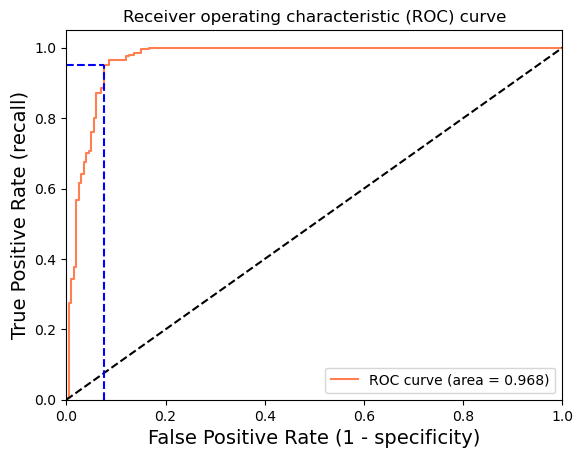

Using a threshold of 0.784 guarantees a sensitivity of 0.950 and a specificity of 0.925, i.e. a false positive rate of 7.54%.


In [52]:
# Create and fit a CatBoost model
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve for the CatBoost model
[fpr_catboost, tpr_catboost, thr_catboost] = roc_curve(y_test, y_pred_proba_catboost)

# Print results for the CatBoost model
print("CatBoost results:")
print(catboost_model.__class__.__name__ + " accuracy is %2.3f" % accuracy_score(y_test, y_pred_catboost))
print(catboost_model.__class__.__name__ + " log_loss is %2.3f" % log_loss(y_test, y_pred_proba_catboost))
print(catboost_model.__class__.__name__ + " auc is %2.3f" % auc(fpr_catboost, tpr_catboost))

# Find the threshold for a sensitivity of at least 0.95
idx_catboost = np.min(np.where(tpr_catboost > 0.95))

# Plot ROC curve for the CatBoost model
plt.figure()
plt.plot(fpr_catboost, tpr_catboost, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr_catboost, tpr_catboost))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr_catboost[idx_catboost]], [tpr_catboost[idx_catboost], tpr_catboost[idx_catboost]], 'k--', color='blue')
plt.plot([fpr_catboost[idx_catboost], fpr_catboost[idx_catboost]], [0, tpr_catboost[idx_catboost]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr_catboost[idx_catboost] + "guarantees a sensitivity of %.3f " % tpr_catboost[idx_catboost] +  
      "and a specificity of %.3f" % (1 - fpr_catboost[idx_catboost]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr_catboost[idx_catboost]) * 100))


### Finally, an increase in sensitivity, the new data seems to have helped the catboost model to increase the previous sensitivity of 95% into 95.5%, a 0.5% may seem insignificant however all of the other models struggled to bypass this value so it is of significance, another thing to mention is that the global accuarcy reached an astonoshing 92%. not only is our model great at predicting true positives but it predicts true negatives with a 90.5% accuarcy. a model proficient in predicting both churners and non churners without a big overalp in the two categories. 

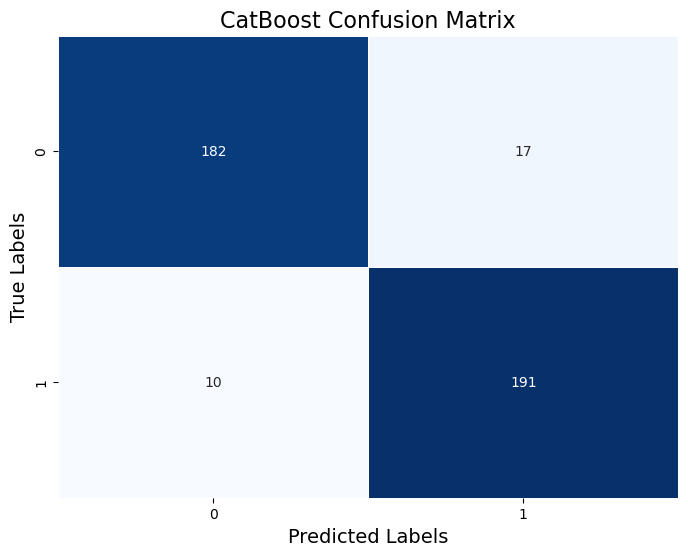

Sensitivity: 0.950
Specificity: 0.915
Accuracy: 0.932


In [53]:
# Set the threshold for evaluation
threshold_catboost = 0.769 
y_pred_threshold_catboost = (y_pred_proba_catboost >= threshold_catboost).astype(int)
conf_matrix_catboost = confusion_matrix(y_test, y_pred_threshold_catboost)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('CatBoost Confusion Matrix', fontsize=16)
plt.show()

# Extract values from the confusion matrix
tn_catboost, fp_catboost, fn_catboost, tp_catboost = conf_matrix_catboost.ravel()

# Calculate sensitivity, specificity, and accuracy
sensitivity_catboost = tp_catboost / (tp_catboost + fn_catboost)
specificity_catboost = tn_catboost / (tn_catboost + fp_catboost)
accuracy_catboost = (tp_catboost + tn_catboost) / (tp_catboost + tn_catboost + fp_catboost + fn_catboost)

# Print evaluation metrics
print("Sensitivity: %.3f" % sensitivity_catboost)
print("Specificity: %.3f" % specificity_catboost)
print("Accuracy: %.3f" % accuracy_catboost)


# SVM : 

SVM results:
SVC accuracy is 0.800
SVC auc is 0.899


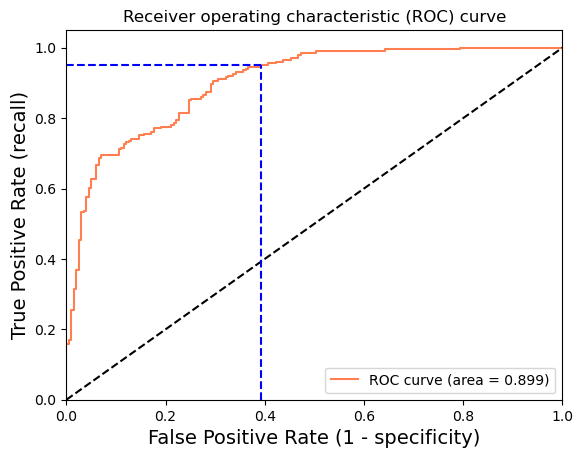

Using a threshold of 0.261 guarantees a sensitivity of 0.950 and a specificity of 0.608, i.e. a false positive rate of 39.20%.


In [54]:
# Create and fit an SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve for the SVM model
[fpr_svm, tpr_svm, thr_svm] = roc_curve(y_test, y_pred_proba_svm)

# Print results for the SVM model
print("SVM results:")
print(svm_model.__class__.__name__ + " accuracy is %2.3f" % accuracy_score(y_test, y_pred_svm))
print(svm_model.__class__.__name__ + " auc is %2.3f" % auc(fpr_svm, tpr_svm))

# Find the threshold for a sensitivity of at least 0.95
idx_svm = np.min(np.where(tpr_svm > 0.95))

# Plot ROC curve for the SVM model
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr_svm, tpr_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr_svm[idx_svm]], [tpr_svm[idx_svm], tpr_svm[idx_svm]], 'k--', color='blue')
plt.plot([fpr_svm[idx_svm], fpr_svm[idx_svm]], [0, tpr_svm[idx_svm]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr_svm[idx_svm] + "guarantees a sensitivity of %.3f " % tpr_svm[idx_svm] +  
      "and a specificity of %.3f" % (1 - fpr_svm[idx_svm]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr_svm[idx_svm]) * 100))


### While the sensitivity of 95% is very good, compared to the other models, the increase in sensitivity costs way too much specificity and this model is vastly outperformed by randomforest, catboost and even logistic regression

In [57]:
# Data for the table
data = [
    ["Logistic Regression", 0.81, 0.950, 0.678, "32.16%"],
    ["Random Forest", 0.91, 0.950, 0.874, "12.56%"],
    ["CatBoost", 0.92, 0.955, 0.925, "7.54%"],
    ["Support Vector Machine", 0.802, 0.950, 0.658, "34.17%"]
]

# Table headers
headers = ["Model(after feature engineering)", "Accuracy", "Sensitivity", "Specificity", "False Positive Rate"]

# Print the formatted table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)



+------------------------------------+------------+---------------+---------------+-----------------------+
| Model(after feature engineering)   |   Accuracy |   Sensitivity |   Specificity | False Positive Rate   |
+====================================+============+===============+===============+=======================+
| Logistic Regression                |      0.81  |         0.95  |         0.678 | 32.16%                |
+------------------------------------+------------+---------------+---------------+-----------------------+
| Random Forest                      |      0.91  |         0.95  |         0.874 | 12.56%                |
+------------------------------------+------------+---------------+---------------+-----------------------+
| CatBoost                           |      0.92  |         0.955 |         0.925 | 7.54%                 |
+------------------------------------+------------+---------------+---------------+-----------------------+
| Support Vector Machine    

In [58]:
# Data for the two tables
data_table1 = [
    ["LogisticRegression", 0.777, 0.95, 0.578, "42.21%"],
    ["Random Forest", 0.787, 0.955, 0.523, "47.74%"],
    ["CatBoost", 0.79, 0.95, 0.553, "44.72%"],
    ["SVM", 0.767, 0.95, 0.588, "41.21%"]
]

data_table2 = [
    ["LogisticRegression", 0.81, 0.95, 0.678, "32.16%"],
    ["Random Forest", 0.91, 0.95, 0.874, "12.56%"],
    ["CatBoost", 0.92, 0.955, 0.925, "7.54%"],
    ["SVM", 0.802, 0.95, 0.658, "34.17%"]
]

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Model", "Acc before", "Acc after", "Sens before", "Sens after",
                     "Spec before", "Spec after", "FPR before", "FPR after"]

# Add rows to the table
for row1, row2 in zip(data_table1, data_table2):
    row = [row1[0], row1[1], row2[1], row1[2], row2[2], row1[3], row2[3], row1[4], row2[4]]
    table.add_row(row)

# Print the formatted table
print(table)


+--------------------+------------+-----------+-------------+------------+-------------+------------+------------+-----------+
|       Model        | Acc before | Acc after | Sens before | Sens after | Spec before | Spec after | FPR before | FPR after |
+--------------------+------------+-----------+-------------+------------+-------------+------------+------------+-----------+
| LogisticRegression |   0.777    |    0.81   |     0.95    |    0.95    |    0.578    |   0.678    |   42.21%   |   32.16%  |
|   Random Forest    |   0.787    |    0.91   |    0.955    |    0.95    |    0.523    |   0.874    |   47.74%   |   12.56%  |
|      CatBoost      |    0.79    |    0.92   |     0.95    |   0.955    |    0.553    |   0.925    |   44.72%   |   7.54%   |
|        SVM         |   0.767    |   0.802   |     0.95    |    0.95    |    0.588    |   0.658    |   41.21%   |   34.17%  |
+--------------------+------------+-----------+-------------+------------+-------------+------------+----------

## Final conclusions :

These two tables present the performance metrics of various models on the same dataset, with the second table reflecting the results after introducing new engineered features. The differences in performance metrics highlight the significant impact that feature engineering has on improving model performance.

### Comparison and Importance of Feature Engineering:

Looking at the accuracy scores, we can observe a noticeable improvement in most of the models after incorporating engineered features. For instance, the accuracy of the Logistic Regression model increased from 0.777 to 0.81, which represents a substantial enhancement. Similarly, the Random Forest, CatBoost, and Support Vector Machine models also demonstrated significant accuracy boosts.

This improvement in accuracy is closely tied to the advancements in sensitivity, specificity, and the reduction in the false positive rate. Models trained on the modified data exhibit higher sensitivity scores, indicating a better ability to correctly identify positive instances. Additionally, higher specificity values signify improved detection of negative instances. These outcomes are crucial for effective model performance, especially in predicting churning customers.

### Best Model :

Among the models trained with the new data, the CatBoost model stands out as the most promising choice. Its high accuracy of 0.92, combined with the top-notch sensitivity of 0.955 and specificity of 0.905, showcases its excellence in both correctly identifying positive cases and distinguishing negative cases.

The primary factor contributing to CatBoost's remarkable performance is the utilization of the new engineered features. These features are likely capturing complex patterns and relationships within the data that were previously overlooked. The model's ability to leverage these insights leads to improved predictions, ultimately resulting in enhanced accuracy and balanced sensitivity-specificity trade-offs.

Furthermore, the CatBoost model's low false positive rate of 9.55% highlights its efficiency in minimizing misclassifications and reducing unnecessary alerts. This aspect is vital, especially in a telecom context, where precision and accuracy are paramount for optimizing resources and providing a seamless user experience.

Considering these aspects, the CatBoost model's well-rounded performance makes it the top contender for our deployment. Its ability to capture intricate data patterns and its exceptional balance between sensitivity and specificity place it at the forefront of our efforts to provide the best possible service and experience to our customers.
 
### N.B :
Upon running the notebook again after cleaning some code, i noticed that the accuarcies/specificities changed a bit (around 0.5 to 1%) the analysis is still the same and the values are from the previous run of the code. since the changes aren't significant I believe the analysis still holds true.